# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score

% matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Part I: Data Understanding

We will have a initial look at the dataset to understand more what are available for analysis

## 1. Portfolio

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


There are total 10 types of different portfolioes avaialbe in the system. 

The _channels_ columns contain multiple values stored in single record. A quick look at other 2 datasets show that there are no more information about with which channel user view the offers so this might not be useful for further analysis. We will drop this column in the data preparation step.

## 2. Profile

In [4]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


There are total 17000 profiles in the system, where columns _age_, _became_member_on_, _id_ contain no missing values while _gender_ and _income_ have about 13% of informaion missing. Those information can be considered sensitive information so a number of users are not willing to share

In [5]:
profile.head(20)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


The _became_member_on_ column is actually the date stored as integer in the format of _YYYYMMDD_. However in the _transcript_ dataset, we can see that the date of event is stored as the number of hours in the start of the experiment. Therefore, this _became_member_on_ information might not be useful for analysis and will be dropped in data preparation step

In [6]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


Histogram of age distribution


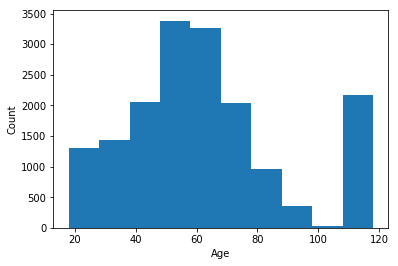

In [7]:
plt.xlabel('Age')
plt.ylabel('Count')
plt.hist(profile.age)
print('Histogram of age distribution')

We can observe there are a number of outliers for customer age (extreme to be 118 for the maximum). Apart from this, the distribution of age has the shape close to normal distribution, with the center at about 50-70. We will not eliminate those outlier for now as the gender and income information can still be useful. When a model is built, those outliers will be removed

Pie chart for distribute of customer gender


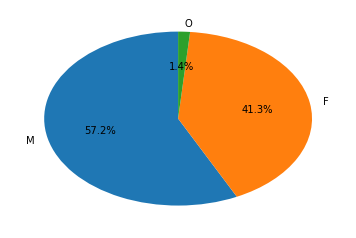

In [8]:
gender_count = profile.gender.value_counts()
plt.pie(gender_count, labels=gender_count.index, startangle=90, autopct='%.1f%%')
print('Pie chart for distribute of customer gender')

From this dataset, male customers contributes about 57% of the dataset while female percentage is 41% and a small portion of 1.4% for other rather than M or F

## 3. Transcript

In [9]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In this dataset, there are no missing data to deal with

In [10]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

There are 4 different types of events, on which the value would depend. We will examine each type of event and their value:

In [11]:
# for easy reference, we attach an id to each event, simply with the indices in the dataframe
transcript = transcript.reset_index().rename(columns={'index': 'event_id'})
transcript

,event_id,event,person,time,value
0,0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [12]:
# extract each event into separate dataframe
transaction_evt = transcript[transcript.event == 'transaction']
offer_received_evt = transcript[transcript.event == 'offer received'].reset_index(drop=True)
offer_viewed_evt = transcript[transcript.event == 'offer viewed'].reset_index(drop=True)
offer_completed_evt = transcript[transcript.event == 'offer completed'].reset_index(drop=True)

In [13]:
def check_value_key(df_with_value, key_list):
    '''
    INPUT:
    df_with_value: a dataframe with 'value' column containing dictionary
    key_list: expected key list of the dictionary
    
    OUTPUT:
    return whether all records in value column has the expected key_list
    '''
    check_key_value = df_with_value.value.map(lambda value_dict: sorted(list(value_dict.keys())) == sorted(key_list))
    print('Total number of records:', df_with_value.shape[0])
    print('The number of record with key %s: %s' % (key_list, check_key_value.sum()))
    assert check_key_value.sum() == df_with_value.shape[0]


def convert_value_column(df_with_value, value_keys):
    '''
    INPUT:
    df_with_value: a dataframe with 'value' column containing dictionary
    value_keys: a list of expected keys in value column
    
    OUTPUT:
    a dataframe with 'value' column replaced with individual columns based on the key of value dictionary
    '''
    for key in value_keys:
        new_column = '_'.join(key.split())
        df_with_value[new_column] = df_with_value.value.map(lambda value_dict: value_dict[key])
    return df_with_value.drop('value', axis=1)


def check_column_value_in_list(df, column, values):
    '''
    INPUT:
    df: a dataframe
    column: a column of the dataframe df
    values: accepted list of values of the column
    OUTPUT:
    return whether all value under that column belong to accepted value list
    
    '''
    actual_column_values = set(df[column].value_counts().index.tolist())
    valid = actual_column_values.issubset(set(values))
    if valid:
        print('All values in column %s are valid' % column)
    else:
        print('Not all values in column %s are valid' % column)
    assert valid

### 3.1. Transaction event

In [14]:
transaction_evt.head(10)

,event_id,event,person,time,value
12654,12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}
12678,12678,transaction,629fc02d56414d91bca360decdfa9288,0,{'amount': 33.9}
12686,12686,transaction,bbeb54e861614fc7b22a8844f72dca6c,0,{'amount': 0.22}
12687,12687,transaction,a97e6f33219c432db82acfa0d19c602d,0,{'amount': 18.59}
12691,12691,transaction,676506bad68e4161b9bbaffeb039626b,0,{'amount': 18.01}
12696,12696,transaction,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'amount': 19.11}


In [15]:
check_value_key(transaction_evt, ['amount'])

Total number of records: 138953
The number of record with key ['amount']: 138953


There are total 138953 transaction events. The _value_ column contains information about amount of the transaction. We can extend a new column for amount

In [16]:
transaction_evt = convert_value_column(transaction_evt, ['amount'])
transaction_evt.head(10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,event_id,event,person,time,amount
12654,12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23
12670,12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97
12678,12678,transaction,629fc02d56414d91bca360decdfa9288,0,33.90
12686,12686,transaction,bbeb54e861614fc7b22a8844f72dca6c,0,0.22
12687,12687,transaction,a97e6f33219c432db82acfa0d19c602d,0,18.59
12691,12691,transaction,676506bad68e4161b9bbaffeb039626b,0,18.01
12696,12696,transaction,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,19.11


### 3.2. Offer received event

In [17]:
offer_received_evt.head(10)

,event_id,event,person,time,value
0,0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


There are total 76277 offer received events. The _value_ column contain informaion about offer_id

In [18]:
check_value_key(offer_received_evt, ['offer id'])

Total number of records: 76277
The number of record with key ['offer id']: 76277


In [19]:
offer_received_evt = convert_value_column(offer_received_evt, ['offer id'])
offer_received_evt.head(10)

,event_id,event,person,time,offer_id
0,0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0
5,5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
6,6,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2
7,7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed
8,8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,9,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


Double check the value of offer_id consistent with portfolio data

In [20]:
offer_ids = portfolio['id'].value_counts().index.tolist()
check_column_value_in_list(offer_received_evt, 'offer_id', offer_ids)

All values in column offer_id are valid


### 3.3. Offer viewed

In [21]:
offer_viewed_evt.head(10)

,event_id,event,person,time,value
0,12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
1,12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
2,12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
3,12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
4,12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
5,12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
6,12660,offer viewed,8c7df0c393db488aac3e58b06a7ea5f9,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,12661,offer viewed,e528ceb341964128aaf58a59733ec2af,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
8,12662,offer viewed,262ad0fb526a4d53b572007da60cce24,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
9,12663,offer viewed,53bac762af27471eb294ff89ca1bae2c,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [22]:
check_value_key(offer_viewed_evt, ['offer id'])

Total number of records: 57725
The number of record with key ['offer id']: 57725


In [23]:
offer_viewed_evt = convert_value_column(offer_viewed_evt, ['offer id'])
offer_viewed_evt.head(10)

,event_id,event,person,time,offer_id
0,12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
1,12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837
2,12652,offer viewed,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0
3,12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
4,12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837
5,12656,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5
6,12660,offer viewed,8c7df0c393db488aac3e58b06a7ea5f9,0,2298d6c36e964ae4a3e7e9706d1fb8c2
7,12661,offer viewed,e528ceb341964128aaf58a59733ec2af,0,2298d6c36e964ae4a3e7e9706d1fb8c2
8,12662,offer viewed,262ad0fb526a4d53b572007da60cce24,0,f19421c1d4aa40978ebb69ca19b0e20d
9,12663,offer viewed,53bac762af27471eb294ff89ca1bae2c,0,fafdcd668e3743c1bb461111dcafc2a4


Double check consistency with offer id from portfolio

In [24]:
check_column_value_in_list(offer_viewed_evt, 'offer_id', offer_ids)

All values in column offer_id are valid


There are total 57725 offer viewed events. Value column contains information about offer id

### 3.4. Offer complete

In [25]:
offer_completed_evt.head(10)

,event_id,event,person,time,value
0,12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
1,12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
2,12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
3,12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
4,12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
5,12717,offer completed,227f2d69e46a4899b70d48182822cff6,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
6,12721,offer completed,bb0f25e23a4c4de6a645527c275cd594,0,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
7,12744,offer completed,d72d201be5794279aa716d8ad82b8d90,0,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
8,12764,offer completed,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
9,12767,offer completed,3e621194f72e40d7a0b695ee9b7c38b7,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [26]:
check_value_key(offer_completed_evt, ['offer_id', 'reward'])

Total number of records: 33579
The number of record with key ['offer_id', 'reward']: 33579


In [27]:
offer_completed_evt = convert_value_column(offer_completed_evt, ['offer_id', 'reward'])
offer_completed_evt.head(10)

,event_id,event,person,time,offer_id,reward
0,12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,2
1,12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,2
2,12679,offer completed,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
3,12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,10
4,12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10
5,12717,offer completed,227f2d69e46a4899b70d48182822cff6,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10
6,12721,offer completed,bb0f25e23a4c4de6a645527c275cd594,0,2298d6c36e964ae4a3e7e9706d1fb8c2,3
7,12744,offer completed,d72d201be5794279aa716d8ad82b8d90,0,f19421c1d4aa40978ebb69ca19b0e20d,5
8,12764,offer completed,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,2906b810c7d4411798c6938adc9daaa5,2
9,12767,offer completed,3e621194f72e40d7a0b695ee9b7c38b7,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10


Double check consistency with offer id in portfolio

In [28]:
check_column_value_in_list(offer_completed_evt, 'offer_id', offer_ids)

All values in column offer_id are valid


Double check reward value is consistent with portfolio data

In [29]:
valid_reward = (offer_completed_evt.reward == offer_completed_evt.offer_id.map(lambda oid: portfolio[portfolio['id'] == oid].reward.iloc[0])).all()
assert valid_reward, 'Not all reward values are consistent with portfolio'

# Part II. Descriptive Exploration

In [30]:
# drop channels column from portfolio
portfolio = portfolio.drop('channels', axis=1)

# since we have a separate dataframe for each type of event, event columns are no longer necessary
transaction_evt = transaction_evt.drop('event', axis=1)
offer_received_evt = offer_received_evt.drop('event', axis=1)
offer_viewed_evt = offer_viewed_evt.drop('event', axis=1)
offer_completed_evt = offer_completed_evt.drop('event', axis=1)

Before starting, we will do a sanity check on transcript data to confirm:
1. All offers that are viewed by a user must be sent to user first 
2. All offers that are viewed by a user must be within the allowed date range of the specific offer
This check is to make sure there is no system/human error when collecting data. If there are any inconsistent row, we need to remove those records

In [31]:
offer_received_viewed = offer_viewed_evt\
    .merge(offer_received_evt, on=['person', 'offer_id'], how='left', suffixes=['_viewed', '_received'])\
    .merge(portfolio, left_on='offer_id', right_on='id')\
    .drop('id', axis=1)

In [32]:
# filter out the view that is not in the allowed duration of the offer
offer_viewed_in_valid_period = offer_received_viewed.apply(lambda row: 0 <= row['time_viewed'] - row['time_received'] <= row['duration'] * 24, axis=1)
offer_received_viewed = offer_received_viewed[offer_viewed_in_valid_period]
offer_received_viewed

,event_id_viewed,person,time_viewed,offer_id,event_id_received,time_received,difficulty,duration,offer_type,reward
0,12650,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,5,0,5,5,bogo,5
2,12662,262ad0fb526a4d53b572007da60cce24,0,f19421c1d4aa40978ebb69ca19b0e20d,54,0,5,5,bogo,5
4,12664,182e68952b474700b171e21b85c258ac,0,f19421c1d4aa40978ebb69ca19b0e20d,72,0,5,5,bogo,5
6,12666,6d28f18e91324d358d69d1e4b01f1ace,0,f19421c1d4aa40978ebb69ca19b0e20d,80,0,5,5,bogo,5
7,12682,569866874d614a6a9c30d9f1e3a23b8d,0,f19421c1d4aa40978ebb69ca19b0e20d,11161,0,5,5,bogo,5
8,12698,0861b9ca31b741bb8b411b18f82d18f6,0,f19421c1d4aa40978ebb69ca19b0e20d,234,0,5,5,bogo,5
11,12701,fe23d94e175742209abf65cfbc684153,0,f19421c1d4aa40978ebb69ca19b0e20d,260,0,5,5,bogo,5
12,12718,d2d8012642ec43e09c18dd814bd1ec6c,0,f19421c1d4aa40978ebb69ca19b0e20d,311,0,5,5,bogo,5
13,12725,ca369d4c5c0c4bb996bf78ec0b65775b,0,f19421c1d4aa40978ebb69ca19b0e20d,330,0,5,5,bogo,5
14,12741,490b282bfc3945df8ac3bbe54dd400fe,0,f19421c1d4aa40978ebb69ca19b0e20d,8324,0,5,5,bogo,5


In [33]:
# since we do a left join with offer_viewed, we will check if there is any value in time_received column is None
assert offer_received_viewed[offer_received_viewed.isnull()].time_received.sum() == 0

### 1. Identify the group of users that will complete the offer after viewing

We will explore the relationship between different user groups and offer conversion. In detail, we are interested in users that viewed the offer and actually completed the offers after seeing the offer

In [34]:
# From the offers being views as extracted above, we can identify which ones are actually completed 
# within the allowed duration of each offer

offer_viewed_completed = offer_completed_evt \
    .drop('reward', axis=1) \
    .merge(offer_received_viewed, on=['person', 'offer_id']) \
    .rename(columns={'time': 'time_completed', 'event_id': 'event_id_completed'})

offer_completed_in_time = offer_viewed_completed.apply(
    lambda row: 0 <= row['time_viewed'] - row['time_received'] <= row['duration'] * 24 \
            and row['time_completed'] >= row['time_viewed'],
    axis=1
)
offer_viewed_completed_in_time = offer_viewed_completed[offer_completed_in_time].sort_values(['person'])
offer_viewed_completed_in_time

,event_id_completed,person,time_completed,offer_id,event_id_viewed,time_viewed,event_id_received,time_received,difficulty,duration,offer_type,reward
15455,95422,0011e0d4e6b944f998e987f904e8c1e5,252,2298d6c36e964ae4a3e7e9706d1fb8c2,75427,186,56298,168,7,7,discount,3
35536,258980,0011e0d4e6b944f998e987f904e8c1e5,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,177937,432,153697,408,20,10,discount,5
35537,258981,0011e0d4e6b944f998e987f904e8c1e5,576,9b98b8c7a33c4b65b9aebfe6a799e6d9,222679,516,204643,504,5,7,bogo,5
31017,218937,0020c2b971eb4e9188eac86d93036a77,510,4d5c57ea9a6940dd891ad53e9dbe8da0,174774,426,152505,408,10,5,bogo,10
4564,218936,0020c2b971eb4e9188eac86d93036a77,510,fafdcd668e3743c1bb461111dcafc2a4,18431,12,1889,0,10,10,discount,2
4563,31327,0020c2b971eb4e9188eac86d93036a77,54,fafdcd668e3743c1bb461111dcafc2a4,18431,12,1889,0,10,10,discount,2
21218,142543,0020ccbbb6d84e358d3414a3ff76cffd,378,f19421c1d4aa40978ebb69ca19b0e20d,131476,348,117013,336,5,5,bogo,5
37435,273123,0020ccbbb6d84e358d3414a3ff76cffd,600,9b98b8c7a33c4b65b9aebfe6a799e6d9,263808,582,207725,504,5,7,bogo,5
13927,88010,0020ccbbb6d84e358d3414a3ff76cffd,222,2298d6c36e964ae4a3e7e9706d1fb8c2,67584,168,59352,168,7,7,discount,3
21779,216735,003d66b6608740288d6cc97a6903f4f0,504,fafdcd668e3743c1bb461111dcafc2a4,105508,300,55857,168,10,10,discount,2


The following code will give general analysis on different groups of users that completed the offer in time

In [35]:
# extract person id and offer type to analyse
user_offer_interaction = pd.DataFrame(offer_viewed_completed_in_time.groupby(['person', 'offer_id'])['event_id_completed'].count())\
    .reset_index().rename(columns={'event_id_completed': 'offer_completed_count'})
user_offer_interaction

,person,offer_id,offer_completed_count
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,2
5,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1
6,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
7,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1
8,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,3
9,00426fe3ffde4c6b9cb9ad6d077a13ea,fafdcd668e3743c1bb461111dcafc2a4,1


In [36]:
user_offer_interaction_count = user_offer_interaction.pivot(index='person', columns='offer_id', values='offer_completed_count')
user_offer_interaction_count

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN
003d66b6608740288d6cc97a6903f4f0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
00426fe3ffde4c6b9cb9ad6d077a13ea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
004b041fbfe44859945daa2c7f79ee64,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
004c5799adbf42868b9cff0396190900,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0
0056df74b63b4298809f0b375a304cf4,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
0069a50874d846438e58acff5e594725,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [37]:
user_offer_interaction_count.sum(axis=0).sort_values()

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    1781.0
9b98b8c7a33c4b65b9aebfe6a799e6d9    2790.0
2906b810c7d4411798c6938adc9daaa5    2836.0
ae264e3637204a6fb9bb56bc8210ddfd    3425.0
4d5c57ea9a6940dd891ad53e9dbe8da0    3517.0
f19421c1d4aa40978ebb69ca19b0e20d    4472.0
2298d6c36e964ae4a3e7e9706d1fb8c2    5679.0
fafdcd668e3743c1bb461111dcafc2a4    6202.0
dtype: float64

The dataframe user_offer_interaction_count show the count of completing each type of offer for each user. Notice that two offer of type 'informational' are not included here

In [38]:
def get_user_group_for_offer(offer_id):
    '''
    INPUT: 
    offer_id: id of the offer from which customer base to be described
    OUTPUT:
    returns a subset of profile dataframe for users that interacts with input offer
    '''
    user_group_idx = user_offer_interaction_count[~user_offer_interaction_count[offer_id].isnull()].index
    user_group = profile.set_index('id').loc[user_group_idx]
    return user_group


def visualize_user_group(user_group):
    '''
    INPUT:
    user_group: a dataframe that is a subset of profile
    
    OUTPUT:
    
    '''
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_figheight(5)
    f.set_figwidth(15)
    print('\nVisualization')
    
    ax1.set_xlabel('age')
    ax1.set_ylabel('count')
    ax1.set_title('Histogram for age')
    ax1.hist(user_group.age)
    
    ax2.set_xlabel('income')
    ax2.set_ylabel('count')
    ax2.set_title('Histogram for income')
    ax2.hist(user_group.income.dropna())
    
    gender_count = user_group.gender.value_counts()
    ax3.pie(gender_count, labels=gender_count.index, startangle=90, autopct='%.1f%%')
    ax3.set_title('Pie chart for distribute of customer gender')
    plt.show()



In [39]:
offer_ids = user_offer_interaction_count.columns.tolist()

*** Describing offer with id: 0b1e1539f2cc45b7b9fa7c272da2e1d7
               age  became_member_on         income
count  1243.000000      1.243000e+03    1243.000000
mean     56.709574      2.016497e+07   70246.983105
std      15.699681      1.102413e+04   18586.941033
min      18.000000      2.013080e+07   30000.000000
25%      47.000000      2.016033e+07   56000.000000
50%      57.000000      2.017013e+07   70000.000000
75%      67.000000      2.017103e+07   84000.000000
max      99.000000      2.018073e+07  119000.000000

Visualization


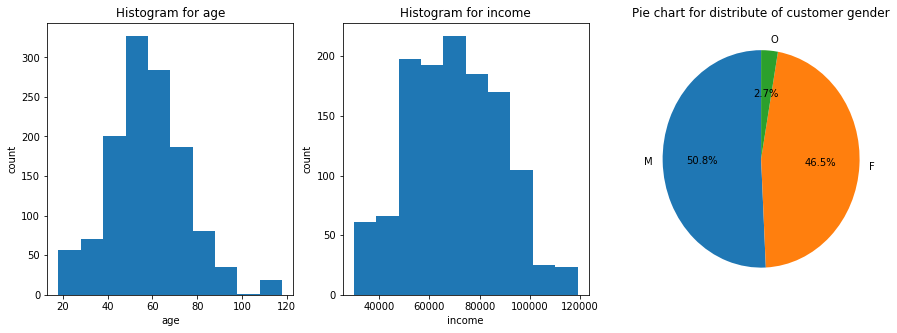

*** Describing offer with id: 2298d6c36e964ae4a3e7e9706d1fb8c2
               age  became_member_on         income
count  3649.000000      3.649000e+03    3649.000000
mean     54.777199      2.016502e+07   66617.703480
std      17.247901      1.185188e+04   21310.412682
min      18.000000      2.013073e+07   30000.000000
25%      43.000000      2.016032e+07   51000.000000
50%      56.000000      2.017031e+07   66000.000000
75%      67.000000      2.017111e+07   81000.000000
max      99.000000      2.018073e+07  120000.000000

Visualization


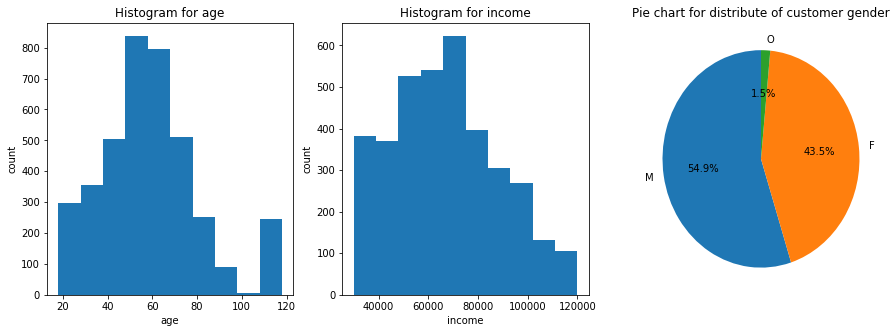

*** Describing offer with id: 2906b810c7d4411798c6938adc9daaa5
               age  became_member_on         income
count  1912.000000      1.912000e+03    1912.000000
mean     55.942992      2.016435e+07   69100.941423
std      15.921852      1.182836e+04   19733.752643
min      18.000000      2.013080e+07   30000.000000
25%      45.000000      2.016021e+07   55000.000000
50%      57.000000      2.017012e+07   68000.000000
75%      67.000000      2.017103e+07   84000.000000
max      99.000000      2.018072e+07  119000.000000

Visualization


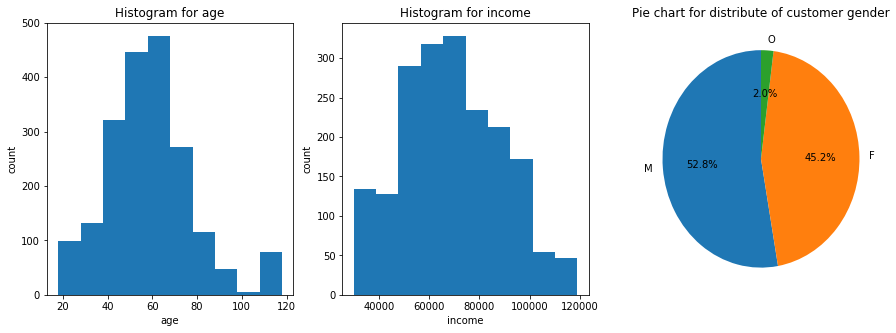

*** Describing offer with id: 4d5c57ea9a6940dd891ad53e9dbe8da0
               age  became_member_on         income
count  2456.000000      2.456000e+03    2456.000000
mean     56.886401      2.016513e+07   72285.423453
std      16.110126      1.042664e+04   21259.419076
min      18.000000      2.013080e+07   30000.000000
25%      47.000000      2.016040e+07   56000.000000
50%      57.000000      2.017022e+07   72000.000000
75%      68.000000      2.017101e+07   87000.000000
max      99.000000      2.018073e+07  120000.000000

Visualization


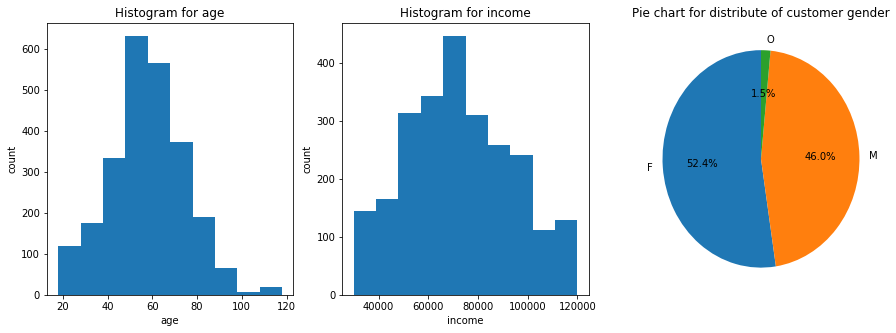

*** Describing offer with id: 9b98b8c7a33c4b65b9aebfe6a799e6d9
               age  became_member_on         income
count  1935.000000      1.935000e+03    1935.000000
mean     55.809819      2.016464e+07   68901.291990
std      16.027768      1.185509e+04   20187.309881
min      18.000000      2.013073e+07   30000.000000
25%      45.000000      2.016021e+07   54000.000000
50%      56.000000      2.017021e+07   68000.000000
75%      67.000000      2.017111e+07   84000.000000
max      99.000000      2.018073e+07  120000.000000

Visualization


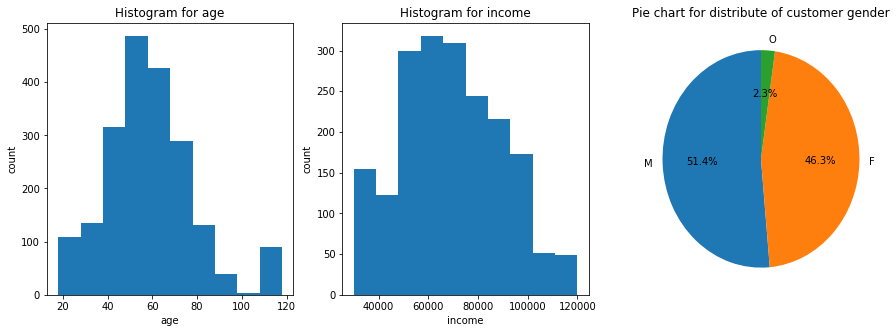

*** Describing offer with id: ae264e3637204a6fb9bb56bc8210ddfd
               age  became_member_on         income
count  2360.000000      2.360000e+03    2360.000000
mean     55.686864      2.016559e+07   70213.135593
std      16.373134      1.036358e+04   21432.502889
min      18.000000      2.013073e+07   30000.000000
25%      45.000000      2.016041e+07   54000.000000
50%      56.000000      2.017022e+07   70000.000000
75%      67.000000      2.017103e+07   86000.000000
max      97.000000      2.018073e+07  120000.000000

Visualization


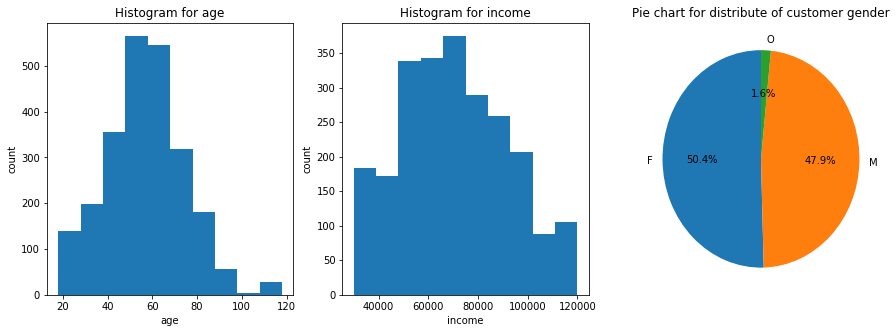

*** Describing offer with id: f19421c1d4aa40978ebb69ca19b0e20d
               age  became_member_on         income
count  3036.000000      3.036000e+03    3036.000000
mean     55.477273      2.016496e+07   68364.295125
std      17.107408      1.129079e+04   21725.523747
min      18.000000      2.013073e+07   30000.000000
25%      44.000000      2.016032e+07   52000.000000
50%      56.000000      2.017022e+07   67000.000000
75%      67.000000      2.017103e+07   84000.000000
max      99.000000      2.018073e+07  120000.000000

Visualization


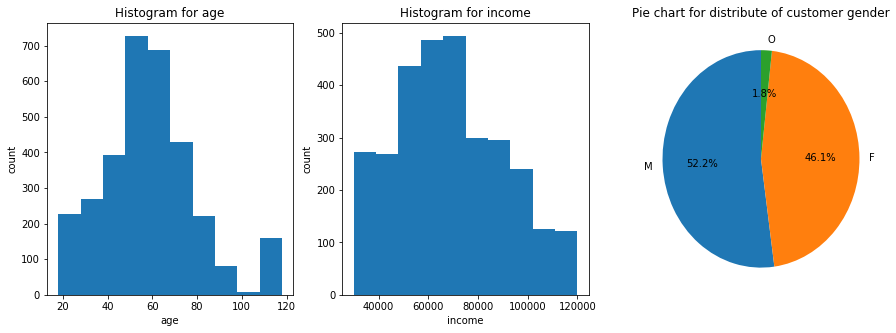

*** Describing offer with id: fafdcd668e3743c1bb461111dcafc2a4
               age  became_member_on         income
count  3815.000000      3.815000e+03    3815.000000
mean     55.000000      2.016453e+07   67207.339450
std      16.887238      1.209787e+04   21713.205468
min      18.000000      2.013073e+07   30000.000000
25%      44.000000      2.016021e+07   51000.000000
50%      56.000000      2.017021e+07   66000.000000
75%      66.000000      2.017111e+07   82000.000000
max      99.000000      2.018073e+07  120000.000000

Visualization


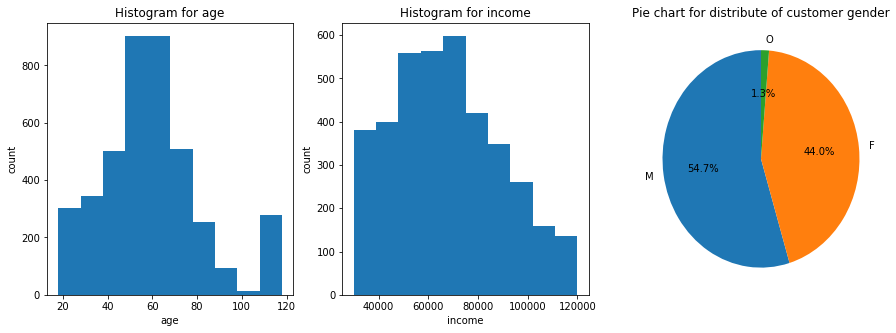

In [40]:
user_groups = {}
for offer_id in offer_ids:
    user_groups[offer_id] = get_user_group_for_offer(offer_id)
    print('*** Describing offer with id:', offer_id)
    print(user_groups[offer_id][user_groups[offer_id].age < 100].describe())
    visualize_user_group(user_groups[offer_id])

**General observations**

1. Top 3 popular offers are: _'f19421c1d4aa40978ebb69ca19b0e20d'_ (bogo type, reward 5 dollars), _'2298d6c36e964ae4a3e7e9706d1fb8c2'_ (discount, spend 7 reward 3 dollars), _'fafdcd668e3743c1bb461111dcafc2a4'_ (discount, spend 10 reward 2). We can consider sedning more of those offers to customers
2. For gender distribution: The overall dataset has 57.2% male, 41.4 female and 1.4% others. Looking at the pie charts for gender distribution of the subset of users that react to each offer, we observe that for most cases, the percentage of female customers increases in comparison with general population. This is true especially for offer with ids _'0b1e1539f2cc45b7b9fa7c272da2e1d7'_ (discount type, spend 20 get 5 dollars), _'9b98b8c7a33c4b65b9aebfe6a799e6d9'_ (bogo type, reward 5 dollars), _'ae264e3637204a6fb9bb56bc8210ddfd'_ (bogo type, reward 10 dollars), _'f19421c1d4aa40978ebb69ca19b0e20d'_ (bogo type, reward 5 dollars), where the difference between male and female drops to about 6% or lower. For those offers, we can consider send more to female users.
3. For all the subsets, the center of age distribution falls at 40-60 years old
4. From income perspective, users with income of 50000 and more respond actively to offers. For lower level of income, the users of this range reacts relatively positive to offer id '2298d6c36e964ae4a3e7e9706d1fb8c2' (discount, spend 7 reward 3) and 'fafdcd668e3743c1bb461111dcafc2a4'(discount, spend 10 reward 2)

### 2. Describe response for each type of offer

In [41]:
offer_viewed_completed_in_time

,event_id_completed,person,time_completed,offer_id,event_id_viewed,time_viewed,event_id_received,time_received,difficulty,duration,offer_type,reward
15455,95422,0011e0d4e6b944f998e987f904e8c1e5,252,2298d6c36e964ae4a3e7e9706d1fb8c2,75427,186,56298,168,7,7,discount,3
35536,258980,0011e0d4e6b944f998e987f904e8c1e5,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,177937,432,153697,408,20,10,discount,5
35537,258981,0011e0d4e6b944f998e987f904e8c1e5,576,9b98b8c7a33c4b65b9aebfe6a799e6d9,222679,516,204643,504,5,7,bogo,5
31017,218937,0020c2b971eb4e9188eac86d93036a77,510,4d5c57ea9a6940dd891ad53e9dbe8da0,174774,426,152505,408,10,5,bogo,10
4564,218936,0020c2b971eb4e9188eac86d93036a77,510,fafdcd668e3743c1bb461111dcafc2a4,18431,12,1889,0,10,10,discount,2
4563,31327,0020c2b971eb4e9188eac86d93036a77,54,fafdcd668e3743c1bb461111dcafc2a4,18431,12,1889,0,10,10,discount,2
21218,142543,0020ccbbb6d84e358d3414a3ff76cffd,378,f19421c1d4aa40978ebb69ca19b0e20d,131476,348,117013,336,5,5,bogo,5
37435,273123,0020ccbbb6d84e358d3414a3ff76cffd,600,9b98b8c7a33c4b65b9aebfe6a799e6d9,263808,582,207725,504,5,7,bogo,5
13927,88010,0020ccbbb6d84e358d3414a3ff76cffd,222,2298d6c36e964ae4a3e7e9706d1fb8c2,67584,168,59352,168,7,7,discount,3
21779,216735,003d66b6608740288d6cc97a6903f4f0,504,fafdcd668e3743c1bb461111dcafc2a4,105508,300,55857,168,10,10,discount,2


In [42]:
offer_received_viewed

,event_id_viewed,person,time_viewed,offer_id,event_id_received,time_received,difficulty,duration,offer_type,reward
0,12650,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,5,0,5,5,bogo,5
2,12662,262ad0fb526a4d53b572007da60cce24,0,f19421c1d4aa40978ebb69ca19b0e20d,54,0,5,5,bogo,5
4,12664,182e68952b474700b171e21b85c258ac,0,f19421c1d4aa40978ebb69ca19b0e20d,72,0,5,5,bogo,5
6,12666,6d28f18e91324d358d69d1e4b01f1ace,0,f19421c1d4aa40978ebb69ca19b0e20d,80,0,5,5,bogo,5
7,12682,569866874d614a6a9c30d9f1e3a23b8d,0,f19421c1d4aa40978ebb69ca19b0e20d,11161,0,5,5,bogo,5
8,12698,0861b9ca31b741bb8b411b18f82d18f6,0,f19421c1d4aa40978ebb69ca19b0e20d,234,0,5,5,bogo,5
11,12701,fe23d94e175742209abf65cfbc684153,0,f19421c1d4aa40978ebb69ca19b0e20d,260,0,5,5,bogo,5
12,12718,d2d8012642ec43e09c18dd814bd1ec6c,0,f19421c1d4aa40978ebb69ca19b0e20d,311,0,5,5,bogo,5
13,12725,ca369d4c5c0c4bb996bf78ec0b65775b,0,f19421c1d4aa40978ebb69ca19b0e20d,330,0,5,5,bogo,5
14,12741,490b282bfc3945df8ac3bbe54dd400fe,0,f19421c1d4aa40978ebb69ca19b0e20d,8324,0,5,5,bogo,5


# Part III. Feature Engineering and Modeling

In this section, we will extract the data and then feed into machine learning algorithm. We will build the model for following questions:
1. For each offer, predict whether a user will response (view and complete)
2. Predict the offer that is most likely to be completed by user

## 1. Predict whether a user will response to an offer

In [43]:
# extract average spending for each user from transactions
average_spend_series = transaction_evt.groupby('person').mean()['amount']
average_spend_series

person
0009655768c64bdeb2e877511632db8f    15.950000
00116118485d4dfda04fdbaba9a87b5c     1.363333
0011e0d4e6b944f998e987f904e8c1e5    15.892000
0020c2b971eb4e9188eac86d93036a77    24.607500
0020ccbbb6d84e358d3414a3ff76cffd    12.837500
003d66b6608740288d6cc97a6903f4f0     2.685556
00426fe3ffde4c6b9cb9ad6d077a13ea     4.030000
004b041fbfe44859945daa2c7f79ee64    23.060000
004c5799adbf42868b9cff0396190900    28.948333
005500a7188546ff8a767329a2f7c76a     5.090000
0056df74b63b4298809f0b375a304cf4    28.828000
0063def0f9c14bc4805322a488839b32     2.403333
0069a50874d846438e58acff5e594725     6.700000
00715b6e55c3431cb56ff7307eb19675    25.008000
0082fd87c18f45f2be70dbcbb0fb8aad    17.407143
00840a2ca5d2408e982d56544dc14ffd     3.701765
00857b24b13f4fe0ad17b605f00357f5     1.565000
008d7088107b468893889da0ede0df5c     2.311429
0091d2b6a5ea4defaa8393e4e816db60    23.263333
0092a132ead946ceb30d11a1ed513d20     0.846667
0099bf30e4cb4265875266eb3eb25eab    11.758889
009d10c2c38a4fd795a7bc6ddbb

In [44]:
# extract feature from profile dataframe
profile['became_member_on_year'] = profile.became_member_on.map(lambda date_str: str(date_str)[:4])
profile['became_member_on_month'] = profile.became_member_on.map(lambda date_str: str(date_str)[4:6])
profile['became_member_on_day'] = profile.became_member_on.map(lambda date_str: str(date_str)[-2:])
profile = pd.get_dummies(profile.rename({'id': 'person'}, axis=1).drop('became_member_on', axis=1).set_index('person'))
profile

,age,income,gender_F,gender_M,gender_O,became_member_on_year_2013,became_member_on_year_2014,became_member_on_year_2015,became_member_on_year_2016,became_member_on_year_2017,...,became_member_on_day_22,became_member_on_day_23,became_member_on_day_24,became_member_on_day_25,became_member_on_day_26,became_member_on_day_27,became_member_on_day_28,became_member_on_day_29,became_member_on_day_30,became_member_on_day_31
person,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,118,NaN,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
0610b486422d4921ae7d2bf64640c50b,55,112000.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
38fe809add3b4fcf9315a9694bb96ff5,118,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
a03223e636434f42ac4c3df47e8bac43,118,NaN,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
e2127556f4f64592b11af22de27a7932,68,70000.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8ec6ce2a7e7949b1bf142def7d0e0586,118,NaN,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
68617ca6246f4fbc85e91a2a49552598,118,NaN,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
389bc3fa690240e798340f5a15918d5c,65,53000.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
dataset = pd.notna(user_offer_interaction_count)
dataset.columns.name = None
dataset['average_spend'] = average_spend_series
dataset = dataset.join(profile)
dataset

,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4,average_spend,age,...,became_member_on_day_22,became_member_on_day_23,became_member_on_day_24,became_member_on_day_25,became_member_on_day_26,became_member_on_day_27,became_member_on_day_28,became_member_on_day_29,became_member_on_day_30,became_member_on_day_31
person,,,,,,,,,,,,,,,,,,,,,
0011e0d4e6b944f998e987f904e8c1e5,True,True,False,False,True,False,False,False,15.892000,40,...,0,0,0,0,0,0,0,0,0,0
0020c2b971eb4e9188eac86d93036a77,False,False,False,True,False,False,False,True,24.607500,59,...,0,0,0,0,0,0,0,0,0,0
0020ccbbb6d84e358d3414a3ff76cffd,False,True,False,False,True,False,True,False,12.837500,24,...,0,0,0,0,0,0,0,0,0,0
003d66b6608740288d6cc97a6903f4f0,False,False,False,False,False,False,False,True,2.685556,26,...,0,0,0,0,0,0,0,0,0,0
00426fe3ffde4c6b9cb9ad6d077a13ea,False,False,False,False,False,False,False,True,4.030000,19,...,0,0,0,0,0,0,0,0,0,0
004b041fbfe44859945daa2c7f79ee64,False,False,False,False,False,False,True,True,23.060000,55,...,0,0,0,0,0,0,0,0,0,0
004c5799adbf42868b9cff0396190900,False,False,False,False,False,False,True,True,28.948333,54,...,0,0,0,0,0,0,0,0,0,1
0056df74b63b4298809f0b375a304cf4,False,False,False,False,True,False,False,False,28.828000,54,...,0,0,0,0,0,0,0,0,0,0
0069a50874d846438e58acff5e594725,False,False,True,False,False,False,False,False,6.700000,118,...,0,0,0,0,0,0,0,0,0,0


In [46]:
# drop age outlier: from the histogram on profiles, we can safely assume that any age greater than 100 is outlier
dataset = dataset[dataset.age < 100]

# The first 8 columns are for 
X, Y = dataset.iloc[:, 8:], dataset.iloc[:, :8]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [47]:
def scale_columns(train_df, test_df, columns):
    scaler = StandardScaler()
    train_df.loc[:, columns] = scaler.fit_transform(train_df.loc[:, columns])
    test_df.loc[:, columns] = scaler.transform(test_df.loc[:, columns])
    return train_df, test_df

In [48]:
# scale average_spend, age, income columns
scaled_columns = ['average_spend', 'age', 'income']
X_train, X_test = scale_columns(X_train, X_test, scaled_columns)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [49]:
# since we have multiple offer to predict, we will use MultiOutputClassifier to wrap the actual classifier
# In this case, the algorithm used is Random Forest Classifier
# we also use Grid Search to find the best parameters for the algorithm

params = {}
clf = MultiOutputClassifier(RandomForestClassifier())
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

In [50]:
# evaluation model

col_count = Y_pred.shape[1]

for col_idx in range(col_count):
    print('column:', offer_ids[col_idx])
    cat_pred = Y_pred[:, col_idx]
    cat_test = Y_test.iloc[:, col_idx]
    print(classification_report(cat_test, cat_pred))

column: 0b1e1539f2cc45b7b9fa7c272da2e1d7
             precision    recall  f1-score   support

      False       0.88      1.00      0.93      1929
       True       0.00      0.00      0.00       266

avg / total       0.77      0.87      0.82      2195

column: 2298d6c36e964ae4a3e7e9706d1fb8c2
             precision    recall  f1-score   support

      False       0.67      0.86      0.75      1463
       True       0.33      0.13      0.19       732

avg / total       0.55      0.62      0.56      2195

column: 2906b810c7d4411798c6938adc9daaa5
             precision    recall  f1-score   support

      False       0.83      0.98      0.90      1822
       True       0.27      0.03      0.06       373

avg / total       0.74      0.82      0.76      2195

column: 4d5c57ea9a6940dd891ad53e9dbe8da0
             precision    recall  f1-score   support

      False       0.77      0.95      0.85      1684
       True       0.32      0.08      0.13       511

avg / total       0.67      0.

From the classification reports above, we can see that for all offers, the F1 scores are all above 0.5 and most are about 0.7. We can use this classifier to predict whether a user will response to the offer.

## 2. Predict the most likely offer that will be completed by a user

In [51]:
user_offer_interaction_count

,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN
003d66b6608740288d6cc97a6903f4f0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
00426fe3ffde4c6b9cb9ad6d077a13ea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
004b041fbfe44859945daa2c7f79ee64,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
004c5799adbf42868b9cff0396190900,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0
0056df74b63b4298809f0b375a304cf4,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
0069a50874d846438e58acff5e594725,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [52]:
most_likely_offer = user_offer_interaction_count.apply(lambda row: row.idxmax(), axis=1)
most_likely_offer

person
0011e0d4e6b944f998e987f904e8c1e5    0b1e1539f2cc45b7b9fa7c272da2e1d7
0020c2b971eb4e9188eac86d93036a77    fafdcd668e3743c1bb461111dcafc2a4
0020ccbbb6d84e358d3414a3ff76cffd    2298d6c36e964ae4a3e7e9706d1fb8c2
003d66b6608740288d6cc97a6903f4f0    fafdcd668e3743c1bb461111dcafc2a4
00426fe3ffde4c6b9cb9ad6d077a13ea    fafdcd668e3743c1bb461111dcafc2a4
004b041fbfe44859945daa2c7f79ee64    f19421c1d4aa40978ebb69ca19b0e20d
004c5799adbf42868b9cff0396190900    f19421c1d4aa40978ebb69ca19b0e20d
0056df74b63b4298809f0b375a304cf4    9b98b8c7a33c4b65b9aebfe6a799e6d9
0069a50874d846438e58acff5e594725    2906b810c7d4411798c6938adc9daaa5
00715b6e55c3431cb56ff7307eb19675    0b1e1539f2cc45b7b9fa7c272da2e1d7
0082fd87c18f45f2be70dbcbb0fb8aad    9b98b8c7a33c4b65b9aebfe6a799e6d9
00840a2ca5d2408e982d56544dc14ffd    2906b810c7d4411798c6938adc9daaa5
0091d2b6a5ea4defaa8393e4e816db60    f19421c1d4aa40978ebb69ca19b0e20d
0099bf30e4cb4265875266eb3eb25eab    fafdcd668e3743c1bb461111dcafc2a4
00a794f62b9a48beb58f8f6c02c

In [70]:
dataset = profile.copy()
dataset['average_spend'] = average_spend_series
dataset['most_likely_offer'] = most_likely_offer
dataset = dataset.dropna(subset=['most_likely_offer'])
dataset = dataset[dataset.age <= 100]
dataset

,age,income,gender_F,gender_M,gender_O,became_member_on_year_2013,became_member_on_year_2014,became_member_on_year_2015,became_member_on_year_2016,became_member_on_year_2017,...,became_member_on_day_24,became_member_on_day_25,became_member_on_day_26,became_member_on_day_27,became_member_on_day_28,became_member_on_day_29,became_member_on_day_30,became_member_on_day_31,average_spend,most_likely_offer
person,,,,,,,,,,,,,,,,,,,,,
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,22.752857,9b98b8c7a33c4b65b9aebfe6a799e6d9
e2127556f4f64592b11af22de27a7932,68,70000.0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,19.243333,9b98b8c7a33c4b65b9aebfe6a799e6d9
389bc3fa690240e798340f5a15918d5c,65,53000.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12.143333,f19421c1d4aa40978ebb69ca19b0e20d
2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,3.905000,fafdcd668e3743c1bb461111dcafc2a4
aa4862eba776480b8bb9c68455b8c2e1,61,57000.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,14.258333,4d5c57ea9a6940dd891ad53e9dbe8da0
31dda685af34476cad5bc968bdb01c53,62,71000.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,20.031250,2298d6c36e964ae4a3e7e9706d1fb8c2
62cf5e10845442329191fc246e7bcea3,49,52000.0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,16.012222,ae264e3637204a6fb9bb56bc8210ddfd
6445de3b47274c759400cd68131d91b4,57,42000.0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,3.183333,2298d6c36e964ae4a3e7e9706d1fb8c2
440cf1fd7580490c971d8c651ed962af,40,71000.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,18.792500,2298d6c36e964ae4a3e7e9706d1fb8c2


In [73]:
X, y = dataset.iloc[:, :-1], dataset.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_test = scale_columns(X_train, X_test, scaled_columns)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [75]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_pred, y_test))
# print('F1 Score:', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.185623293904
                                  precision    recall  f1-score   support

0b1e1539f2cc45b7b9fa7c272da2e1d7       0.09      0.11      0.10       203
2298d6c36e964ae4a3e7e9706d1fb8c2       0.26      0.45      0.33       564
2906b810c7d4411798c6938adc9daaa5       0.09      0.07      0.08       232
4d5c57ea9a6940dd891ad53e9dbe8da0       0.19      0.14      0.16       291
9b98b8c7a33c4b65b9aebfe6a799e6d9       0.15      0.07      0.09       195
ae264e3637204a6fb9bb56bc8210ddfd       0.09      0.07      0.08       183
f19421c1d4aa40978ebb69ca19b0e20d       0.13      0.08      0.10       238
fafdcd668e3743c1bb461111dcafc2a4       0.14      0.11      0.12       292

                     avg / total       0.16      0.19      0.16      2198

